In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from scipy import signal
from scipy import fftpack

In [2]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies import Movie
from allensdk.brain_observatory.sync_dataset import Dataset

In [21]:
%matplotlib notebook

### Plot EEG data to show spatial distribution

In [4]:
# coordinates relative to bregma
# ML: neg= mouse left, pos= mouse right

EEG_ML = np.array([-4.05, -2.24, -1.0, -4.13, -2.88, -1.13, -4.05, -2.88, -1.12, -3.5,
                   -2.12, -1.93, -0.5, -1.5, -0.5, 0.5, 1.5, 0.5, 1.93, 2.12,
                   3.5, 1.12, 2.88, 4.05, 1.13, 2.88, 4.13, 1.0, 2.24, 4.05
                  ])

EEG_AP = np.array([-4.14, -4.14, -4.14, -3.04, -3.04, -3.04, -1.96, -1.96, -1.96, -0.48,
                   -0.48, 1.04, 1.04, 2.3, 2.3, 2.3, 2.3, 1.04, 1.04, -0.48,
                   -0.48, -1.96, -1.96, -1.96, -3.04, -3.04, -3.04, -4.14, -4.14, -4.14
                  ])

Text(0.5, 1.0, 'Map of EEG electrodes')

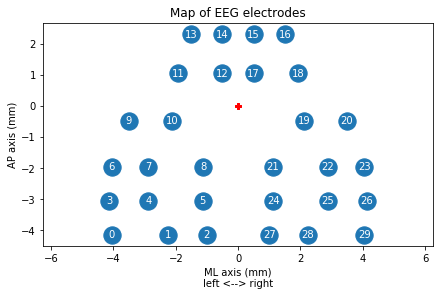

In [5]:
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(EEG_ML, EEG_AP, s=300)
ax.scatter(0, 0, marker='P', color='red')
ax.axis('equal')
    
for ind in range(len(EEG_ML)):
    ax.annotate(str(ind),  xy=(EEG_ML[ind], EEG_AP[ind]), ha='center', va='center', color="w")

ax.set_xlabel('ML axis (mm)\nleft <--> right')
ax.set_ylabel('AP axis (mm)')
ax.set_title('Map of EEG electrodes')

### Let's load some EEG data

In [24]:
data_folder = r"C:\Users\lesliec\data\eeg_pilot\mouse507190\pilot1_2020-02-28_10-33-11\recording1"
exp = EEGexp(data_folder)

In [8]:
dir(exp)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'bits_to_uvolts',
 'data_folder',
 'data_units',
 'eegdata_file',
 'eegtimestamps_file',
 'intanNNmap',
 'load_analog_iso',
 'load_running',
 'load_sync_dataset',
 'memmap_EEGdata',
 'mouse',
 'num_chs',
 'sample_rate',
 'sslog_file',
 'sync_file']

In [11]:
eegdata = np.load(os.path.join(os.path.dirname(exp.eegdata_file), 'data_2500Hz.npy')) * exp.bits_to_uvolts / 1000.
masterts = np.load(os.path.join(os.path.dirname(exp.eegtimestamps_file), 'timestamps_master_2500Hz.npy'))
sample_rate = 2500.

In [12]:
pl_cha = 5
cha = eegdata[:, pl_cha]

#### Load iso data

In [14]:
sync_data = exp.load_sync_dataset()
iso_level, isotime = exp.load_analog_iso(sync_data) # still need to pass it the Dataset instance

C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\allensdk\brain_observatory\sync_dataset.py:454: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return eval(self.dfile['analog_meta'].value)


In [15]:
iso5inds = np.where(iso_level > 4.90)[0]
iso5_times = isotime[np.array([iso5inds[0], iso5inds[-1]])]
print(iso5_times)

iso2inds = np.where((iso_level > 1.80) & (iso_level < 2.2))[0]
iso2inds = iso2inds[iso2inds > iso5inds[-1]] # removes iso2 level during initial increase to iso5
iso2_times = isotime[np.array([iso2inds[0], iso2inds[-1]])]
print(iso2_times)

[ 645.712 1189.232]
[1194.048 1867.552]


#### Load running

In [16]:
linear_velocity, runtime = exp.load_running(sync_data)

In [17]:
# simple mean smoothing filter
smooth_velocity = np.zeros_like(linear_velocity)

# implement the running mean filter
k = 20 # filter window is actually k*2+1
for i in range(k, len(linear_velocity)-k-1):
    # each point is the average of k surrounding points
    smooth_velocity[i] = np.mean(linear_velocity[i-k:i+k])

### Let's try to trigger on at least one of the "bursts"

<IPython.core.display.Javascript object>


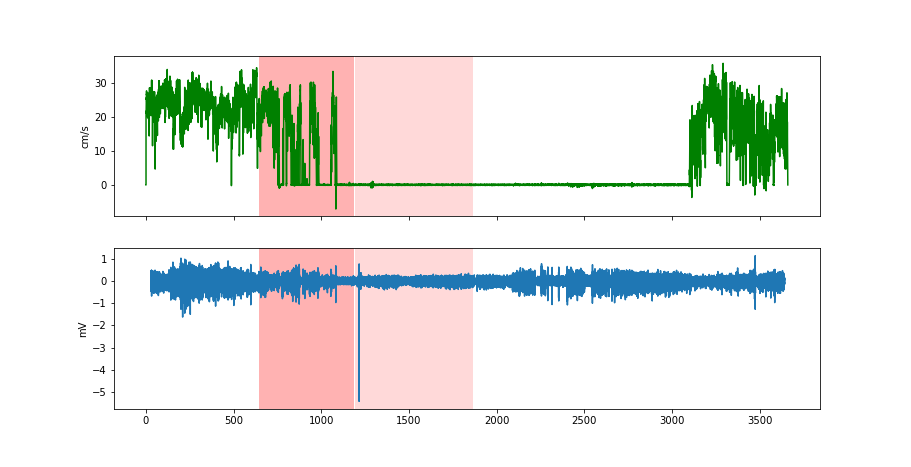

In [23]:
fig, axs = plt.subplots(2,1, sharex=True)

axs[0].plot(runtime, smooth_velocity, 'g')
axs[0].set_ylabel('cm/s')
axs[0].axvspan(iso5_times[0], iso5_times[1], facecolor='r', alpha=0.3)
axs[0].axvspan(iso2_times[0], iso2_times[1], facecolor='r', alpha=0.15)

axs[1].plot(masterts, cha)
axs[1].set_ylabel('mV')
axs[1].axvspan(iso5_times[0], iso5_times[1], facecolor='r', alpha=0.3)
axs[1].axvspan(iso2_times[0], iso2_times[1], facecolor='r', alpha=0.15)

In [36]:
time_beg = 1431.
time_end = 1451.

In [37]:
timeinds = np.where((masterts > time_beg) & (masterts < time_end))[0]
print(np.shape(timeinds))
print(timeinds[0:3])

(50000,)
[3502957 3502958 3502959]


In [16]:
# what is mean of cha in that window vs overall mean
print(np.mean(cha))
print(np.mean(cha[timeinds]))

-8.352547828812796e-05
0.0007823622570174068


Text(0.5, 1.0, 'Map of EEG electrodes')

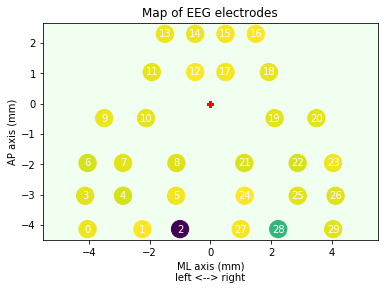

In [16]:
# test plot of electrodes with actual eeg data
fig, ax = plt.subplots()

ax.scatter(EEG_ML, EEG_AP, c=eegdata[timeinds[1000],:], s=300)
ax.scatter(0, 0, marker='P', color='red')
ax.axis('equal')
ax.set_facecolor('honeydew')
    
for ind in range(len(EEG_ML)):
    ax.annotate(str(ind),  xy=(EEG_ML[ind], EEG_AP[ind]), ha='center', va='center', color="w")

ax.set_xlabel('ML axis (mm)\nleft <--> right')
ax.set_ylabel('AP axis (mm)')
ax.set_title('Map of EEG electrodes')

### Need to load movies

In [17]:
body_path = os.path.join(exp.dataLoc, '200228103246-0.avi')
eye_path = os.path.join(exp.dataLoc, '200228103246-1.avi')
face_path = os.path.join(exp.dataLoc, '200228103246-2.avi')
# body cam -0, pupil cam -1, face cam -2

In [18]:
bodymovie = Movie(filepath=body_path,
                 sync_filepath=exp.syncFile,
                 sync_channel='behavior_camera'
                 )

In [19]:
eyemovie = Movie(filepath=eye_path,
                 sync_filepath=exp.syncFile,
                 sync_channel='eye_camera'
                 )

In [20]:
facemovie = Movie(filepath=face_path,
                 sync_filepath=exp.syncFile,
                 sync_channel='face_camera'
                 )

#### Built overall plot with images

In [26]:
jind = timeinds[0]
current_time = masterts[jind]
print(current_time)

1431.0002918302898


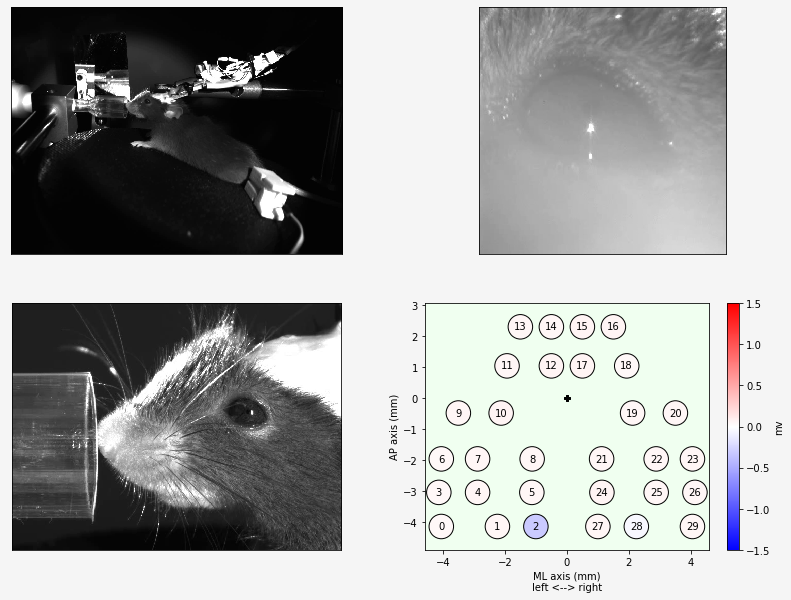

In [52]:
fig = plt.figure(figsize=(14, 10))
fig.patch.set_facecolor('whitesmoke')

# make grid for subplots
gs = GridSpec(2, 2, figure=fig)
ax_body = fig.add_subplot(gs[0, 0])
ax_eye = fig.add_subplot(gs[0, 1])
ax_face = fig.add_subplot(gs[1, 0])
ax_eeg = fig.add_subplot(gs[1, 1])

# body cam movie
ax_body.imshow(bodymovie.get_frame(time=current_time))
ax_body.get_xaxis().set_visible(False)
ax_body.get_yaxis().set_visible(False)

# eye cam movie
ax_eye.imshow(eyemovie.get_frame(time=current_time))
ax_eye.get_xaxis().set_visible(False)
ax_eye.get_yaxis().set_visible(False)

# face cam movie
ax_face.imshow(facemovie.get_frame(time=current_time))
ax_face.get_xaxis().set_visible(False)
ax_face.get_yaxis().set_visible(False)

# EEG plot
bug = ax_eeg.scatter(EEG_ML, EEG_AP, c=eegdata[jind,:], s=600, cmap='bwr', vmin=-1.5, vmax=1.5, edgecolors='k')
ax_eeg.scatter(0, 0, marker='P', color='black')
for ind in range(len(EEG_ML)):
    ax_eeg.annotate(str(ind),  xy=(EEG_ML[ind], EEG_AP[ind]), ha='center', va='center', color="k")
ax_eeg.axis('equal')
ax_eeg.set_facecolor('honeydew')
ax_eeg.set_xlabel('ML axis (mm)\nleft <--> right')
ax_eeg.set_ylabel('AP axis (mm)')
cb = fig.colorbar(bug, ax=ax_eeg)
cb.set_label('mv')

### Animation??

In [38]:
movie_name = os.path.join(exp.data_folder, 'eeg_burst_20s.mp4')
print(movie_name)

C:\Users\lesliec\data\eeg_pilot\mouse507190\pilot1_2020-02-28_10-33-11\recording1\eeg_burst_20s.mp4


In [39]:
def update(frame):
    eegind = timeinds[0:50000:50][frame]
    current_time = masterts[eegind]
    
    # body cam movie
    bax.set_data(bodymovie.get_frame(time=current_time))

    # eye cam movie
    eax.set_data(eyemovie.get_frame(time=current_time))
    
    # face cam movie
    fax.set_data(facemovie.get_frame(time=current_time))

    # EEG plot
    bug.set_array(eegdata[eegind,:])
    
    return fig

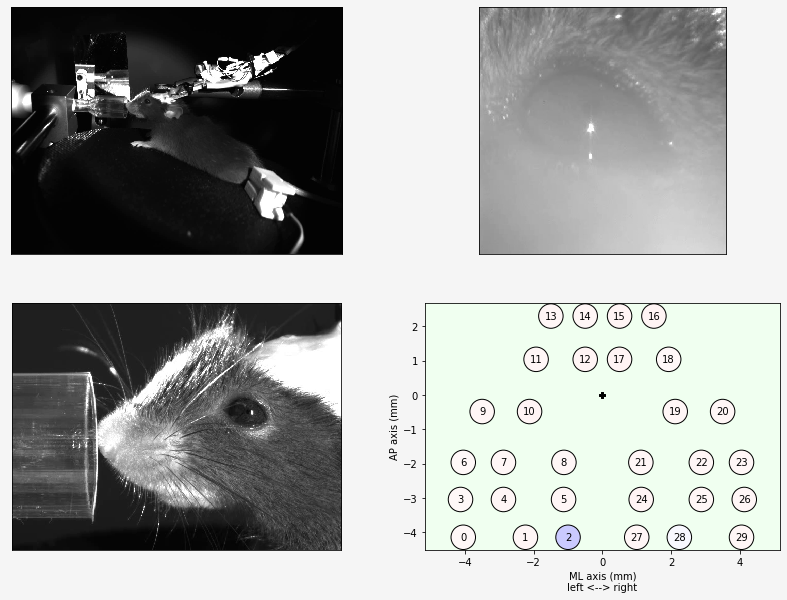

In [40]:
fig = plt.figure(figsize=(14, 10))
fig.patch.set_facecolor('whitesmoke')

jind = timeinds[0]
timezero = masterts[jind]

# make grid for subplots
gs = GridSpec(2, 2, figure=fig)
ax_body = fig.add_subplot(gs[0, 0])
ax_eye = fig.add_subplot(gs[0, 1])
ax_face = fig.add_subplot(gs[1, 0])
ax_eeg = fig.add_subplot(gs[1, 1])

# body cam movie
bax = ax_body.imshow(bodymovie.get_frame(time=timezero))
ax_body.get_xaxis().set_visible(False)
ax_body.get_yaxis().set_visible(False)

# eye cam movie
eax = ax_eye.imshow(eyemovie.get_frame(time=timezero))
ax_eye.get_xaxis().set_visible(False)
ax_eye.get_yaxis().set_visible(False)

# face cam movie
fax = ax_face.imshow(facemovie.get_frame(time=timezero))
ax_face.get_xaxis().set_visible(False)
ax_face.get_yaxis().set_visible(False)

# EEG plot
bug = ax_eeg.scatter(EEG_ML, EEG_AP, c=eegdata[jind,:], s=600, cmap='bwr', vmin=-1.5, vmax=1.5, edgecolors='k')
ax_eeg.scatter(0, 0, marker='P', color='black')
for ind in range(len(EEG_ML)):
    ax_eeg.annotate(str(ind),  xy=(EEG_ML[ind], EEG_AP[ind]), ha='center', va='center', color="k")
ax_eeg.axis('equal')
ax_eeg.set_facecolor('honeydew')
ax_eeg.set_xlabel('ML axis (mm)\nleft <--> right')
ax_eeg.set_ylabel('AP axis (mm)')

## from Ethan
anim = animation.FuncAnimation(fig, update, init_func=None, frames=len(timeinds[0:50000:50]), interval=33, blit=False)
anim.save(movie_name, writer='ffmpeg', fps=30, extra_args=['-vcodec', 'libx264'], dpi=300)

## More plotting and PSD below

### Plot some channels, full time

In [29]:
chs_to_plot = np.array([28, 25, 21, 19, 18, 16]) # [16, 18, 19, 21, 25, 28]

#### Plot chs, but smaller windows

### Pull 10 min chunks to analyze spectral content

In [19]:
timechunk = 10. * 60. # seconds
baseinds = np.arange(0, int(timechunk*sample_rate))
print(len(baseinds))

1500000


In [22]:
wake10 = eegdata[baseinds, :]

In [23]:
anoffset = int((iso2_times[0]-masterts[0])*sample_rate)
an10 = eegdata[baseinds+anoffset, :]

### Power spectral density of signals

In [37]:
welchwinlen = 1 * sample_rate
# nperseg = length of window, power of 2 is most efficient, 2**12 from Doug's notebook
# Signal Processing class uses 2 s window

In [38]:
fw, Pxx_denw = signal.welch(wake10, sample_rate, nperseg=welchwinlen, axis=0)
fa, Pxx_dena = signal.welch(an10, sample_rate, nperseg=welchwinlen, axis=0)

In [27]:
print(np.shape(fw))
print(np.shape(Pxx_denw))

(2501,)
(2501, 30)


In [30]:
wcolor = 'b'
ancolor= 'r'

<IPython.core.display.Javascript object>


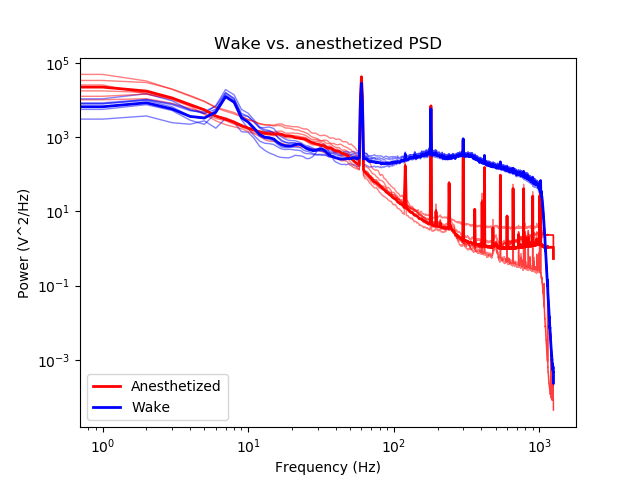

In [39]:
fig, ax = plt.subplots()

for k, plch in enumerate(chs_to_plot):
    ax.loglog(fw, Pxx_denw[:, plch], color=wcolor, linewidth=1, alpha=0.5)
    ax.loglog(fa, Pxx_dena[:, plch], color=ancolor, linewidth=1, alpha=0.5)
    
ax.loglog(fa, np.mean(Pxx_dena, axis=1), color=ancolor, linewidth=2, label=('Anesthetized'))
ax.loglog(fw, np.mean(Pxx_denw, axis=1), color=wcolor, linewidth=2, label=('Wake'))

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (V^2/Hz)')
ax.set_title('Wake vs. anesthetized PSD')
ax.legend()

In [40]:
frinds = fw < 200

<IPython.core.display.Javascript object>


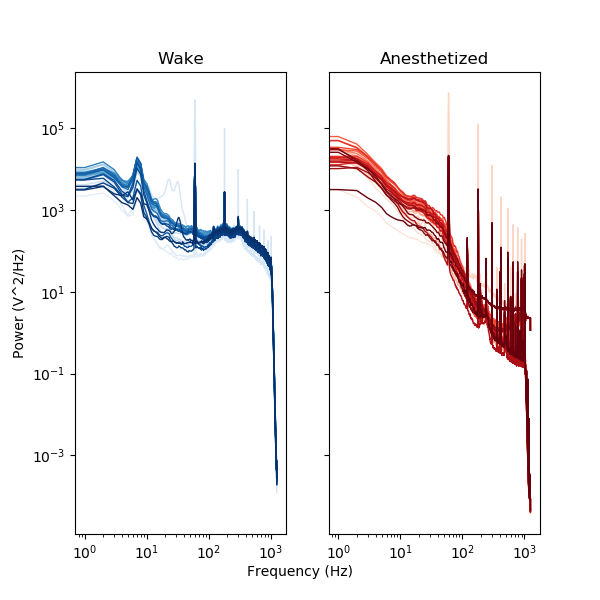

Text(0.5, 0.04, 'Frequency (Hz)')

In [49]:
colr = np.linspace(0.1, 1, 30)
fig, axs = plt.subplots(1, 2, figsize=(6,6), sharey=True)

for plch in range(30):
    axs[0].loglog(fw, Pxx_denw[:, plch], color=plt.cm.Blues(colr[plch]), linewidth=1)
    axs[1].loglog(fa, Pxx_dena[:, plch], color=plt.cm.Reds(colr[plch]), linewidth=1)
    
axs[0].set_title('Wake')
axs[0].set_ylabel('Power (V^2/Hz)')
axs[1].set_title('Anesthetized')
fig.text(0.5, 0.04, 'Frequency (Hz)', ha='center')

<IPython.core.display.Javascript object>


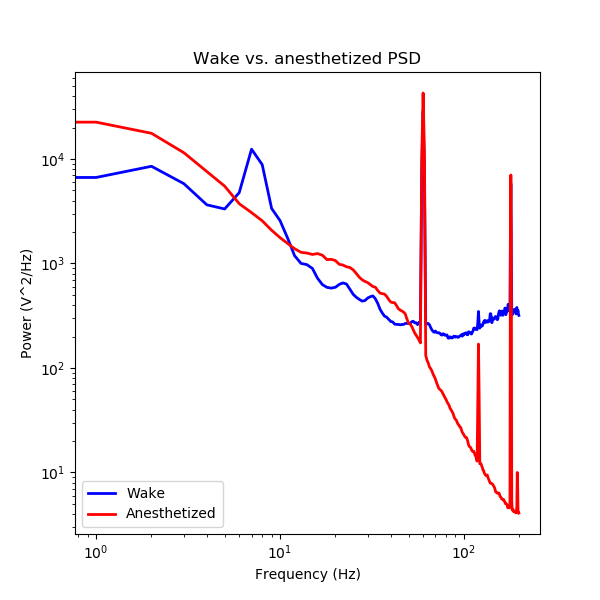

In [51]:
fig, ax = plt.subplots(figsize=(6,6))
    
ax.loglog(fw[frinds], np.mean(Pxx_denw, axis=1)[frinds], color=wcolor, linewidth=2, label=('Wake'))
ax.loglog(fa[frinds], np.mean(Pxx_dena, axis=1)[frinds], color=ancolor, linewidth=2, label=('Anesthetized'))

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (V^2/Hz)')
ax.set_title('Wake vs. anesthetized PSD')
ax.legend()